In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  #report metrics
  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")
  # print(f"Classes: {plot_classes}")

  #plot matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  # return metrics
  return [acc, cnf_matrix]

# Transfer learning for audio

In [ ]:
# !pip install livelossplot

In [ ]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

In [ ]:
main_path = '/gdrive/MyDrive/Projects/ITCproject/'
TESS = os.path.join(main_path, "data3/")
RAV = os.path.join(main_path, "data/")
SAVEE = os.path.join(main_path, "data2/")

dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a04.wav', 'KL_su15.wav', 'DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav']

# RAVDESS

In [ ]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])
            
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

In [ ]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,calm,speech,audio only,strong,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
1,surprised,speech,audio only,normal,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
2,fearful,speech,audio only,normal,male,Kids are talking by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
3,calm,speech,audio only,strong,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
4,surprised,speech,audio only,strong,male,Kids are talking by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...


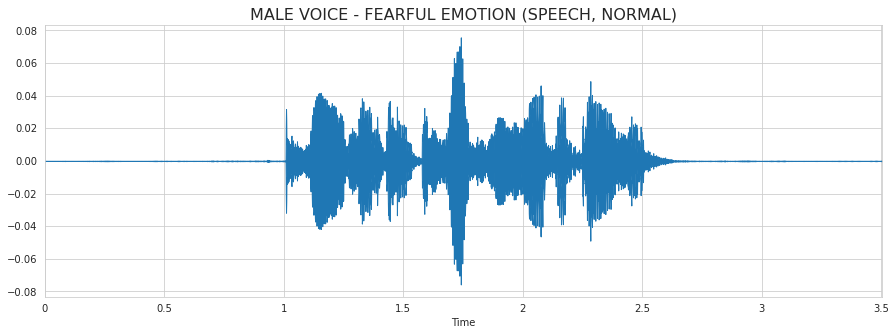

In [ ]:
n_files = df.shape[0]

# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech
fname = df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = df.iloc[rnd].values
title_txt = f'{info[4]} voice - {info[0]} emotion ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
librosa.display.waveplot(data, sr=sampling_rate)

# play the audio 
ipd.Audio(fname)

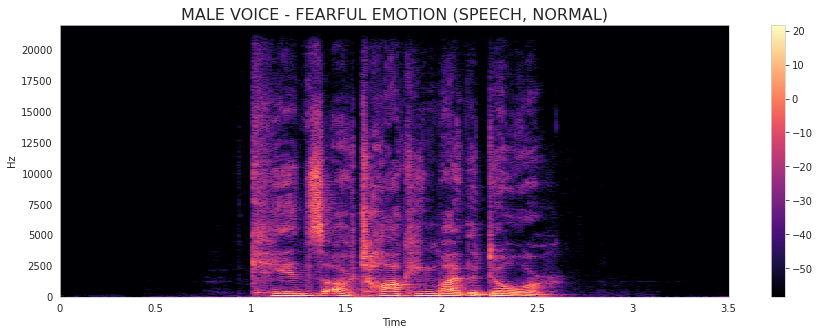

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [ ]:
mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc = 40)

In [ ]:
data.shape, Xdb.shape, mfccs.shape

((154505,), (1025, 302), (40, 302))

# SAVEE

In [ ]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry_male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust_male')
    elif i[-8:-6]=='_f':
        emotion.append('fear_male')
    elif i[-8:-6]=='_h':
        emotion.append('happy_male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral_male')
    elif i[-8:-6]=='sa':
        emotion.append('sad_male')
    elif i[-8:-6]=='su':
        emotion.append('surprise_male')
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral_male     120
angry_male        60
sad_male          60
happy_male        60
disgust_male      60
fear_male         60
surprise_male     60
Name: emotion_label, dtype: int64

In [ ]:
SAVEE_df.head()

,emotion_label,source,path
0,angry_male,SAVEE,/gdrive/MyDrive/Projects/ITCproject/data2/DC_a...
1,surprise_male,SAVEE,/gdrive/MyDrive/Projects/ITCproject/data2/KL_s...
2,angry_male,SAVEE,/gdrive/MyDrive/Projects/ITCproject/data2/DC_a...
3,angry_male,SAVEE,/gdrive/MyDrive/Projects/ITCproject/data2/DC_a...
4,angry_male,SAVEE,/gdrive/MyDrive/Projects/ITCproject/data2/DC_a...


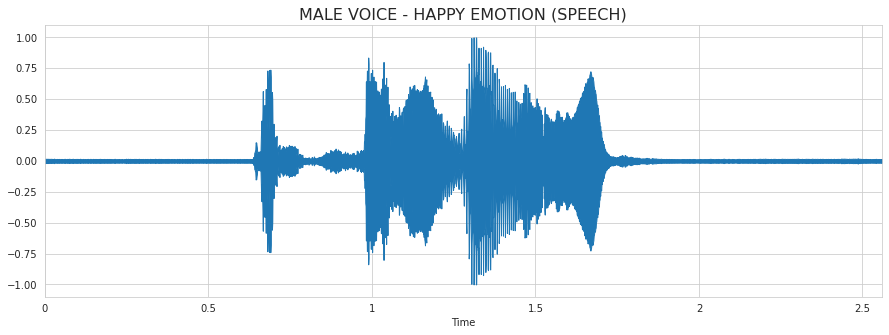

In [ ]:
n_files = SAVEE_df.shape[0]

# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech
fname = SAVEE_df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = SAVEE_df.iloc[rnd].values
title_txt = f'male voice - {info[0][:-5]} emotion (speech)'
plt.title(title_txt.upper(), size=16)
librosa.display.waveplot(data, sr=sampling_rate)

# play the audio 
ipd.Audio(fname)

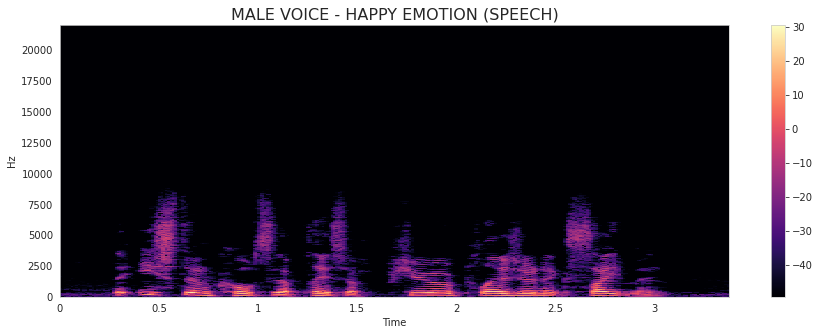

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [ ]:
data.shape, Xdb.shape

((148892,), (1025, 291))

# TESS

In [ ]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'TESS Toronto emotional speech set data',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [ ]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry_female')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust_female')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear_female')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy_female')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral_female')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise_female')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad_female')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

sad_female         400
disgust_female     400
neutral_female     400
surprise_female    400
happy_female       400
fear_female        400
angry_female       400
Unknown             14
Name: emotion_label, dtype: int64

In [ ]:
TESS_df.head()

,emotion_label,source,path
0,fear_female,TESS,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...
1,fear_female,TESS,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...
2,fear_female,TESS,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...
3,fear_female,TESS,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...
4,fear_female,TESS,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...


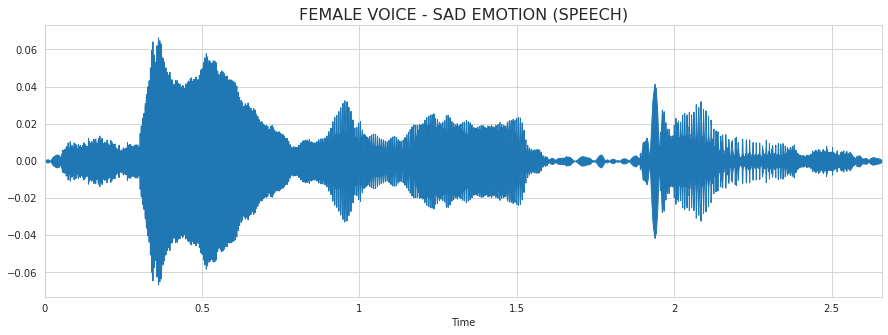

In [ ]:
n_files = TESS_df.shape[0]

# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech
fname = TESS_df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = TESS_df.iloc[rnd].values
title_txt = f'female voice - {info[0][:-7]} emotion (speech)'
plt.title(title_txt.upper(), size=16)
librosa.display.waveplot(data, sr=sampling_rate)

# play the audio 
ipd.Audio(fname)

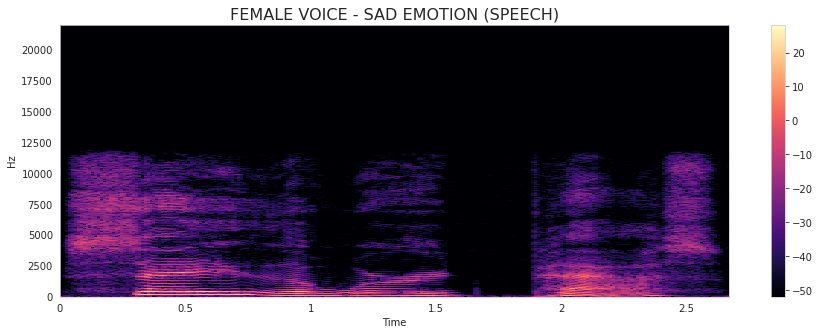

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [ ]:
data.shape, Xdb.shape

((117321,), (1025, 230))

# COMBINING OF DATASETS

In [ ]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,calm,speech,audio only,strong,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
1,surprised,speech,audio only,normal,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
2,fearful,speech,audio only,normal,male,Kids are talking by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
3,calm,speech,audio only,strong,male,Dogs are sitting by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...
4,surprised,speech,audio only,strong,male,Kids are talking by the door,/gdrive/MyDrive/Projects/ITCproject/data/data/...


In [ ]:
RAV_df = df.copy()

# only speech
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df.insert(1, "source", "RAV", True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

,emotion_label,source,actors,path
0,calm_male,RAV,male,/gdrive/MyDrive/Projects/ITCproject/data/data/...
1,surprised_male,RAV,male,/gdrive/MyDrive/Projects/ITCproject/data/data/...
2,fearful_male,RAV,male,/gdrive/MyDrive/Projects/ITCproject/data/data/...
3,calm_male,RAV,male,/gdrive/MyDrive/Projects/ITCproject/data/data/...
4,surprised_male,RAV,male,/gdrive/MyDrive/Projects/ITCproject/data/data/...


In [ ]:
TESS_df.insert(2, "actors", "female", True)
SAVEE_df.insert(2, "actors", "male", True)

In [ ]:
df_combined = pd.concat([TESS_df, RAV_df, SAVEE_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4734 entries, 0 to 479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  4734 non-null   object
 1   source         4734 non-null   object
 2   actors         4734 non-null   object
 3   path           4734 non-null   object
dtypes: object(4)
memory usage: 184.9+ KB


In [ ]:
for col in ['emotion_label', 'source', 'actors']:
    print('\nColumn values for ', col.upper())
    print(df_combined[col].value_counts())


Column values for  EMOTION_LABEL
angry_female        496
sad_female          496
disgust_female      496
happy_female        496
neutral_female      448
surprise_female     400
fear_female         400
neutral_male        168
sad_male            156
happy_male          156
angry_male          156
disgust_male        156
fearful_female       96
calm_male            96
calm_female          96
surprised_female     96
surprised_male       96
fearful_male         96
surprise_male        60
fear_male            60
Unknown              14
Name: emotion_label, dtype: int64

Column values for  SOURCE
TESS     2814
RAV      1440
SAVEE     480
Name: source, dtype: int64

Column values for  ACTORS
female    3534
male      1200
Name: actors, dtype: int64


In [ ]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

df_combined['emotion2'] = df_combined['emotion_label'].map(new_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
1,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
2,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
3,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
4,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female


In [ ]:
addit_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'fear_male','fearful_female':'fear_female',
                        'fear_male':'fear_male', 'fear_female':'fear_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'sad_male', 'sad_female':'sad_female',
                        'surprised_male':'surprise_male', 'surprised_female':'surprise_female',
                        'surprise_male':'surprise_male', 'surprise_female':'surprise_female',
                        'Unknown': 'unk'}

df_combined['emotion3'] = df_combined['emotion_label'].map(addit_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female
1,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female
2,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female
3,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female
4,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female,fear_female


In [ ]:
df_combined.emotion2.value_counts()

negative_female    1984
positive_female     992
negative_male       624
neutral_female      544
positive_male       312
neutral_male        264
unk                  14
Name: emotion2, dtype: int64

In [ ]:
df_combined.emotion3.value_counts()

negative_female    992
neutral_female     544
sad_female         496
surprise_female    496
positive_female    496
fear_female        496
negative_male      312
neutral_male       264
fear_male          156
surprise_male      156
positive_male      156
sad_male           156
Name: emotion3, dtype: int64

In [ ]:
df_combined = df_combined.loc[df_combined['emotion2'] != 'unk']

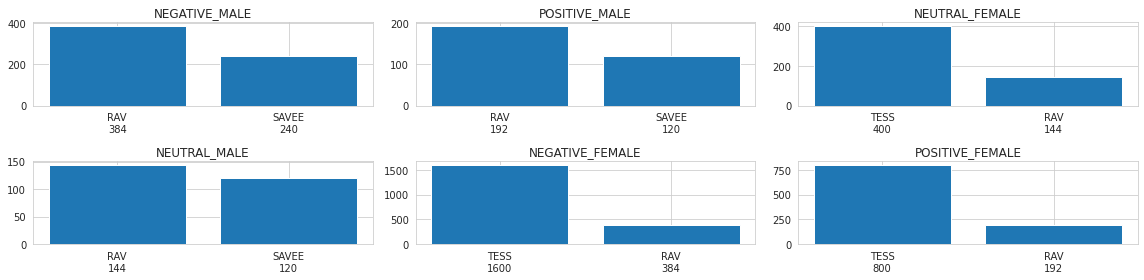

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,4))
for idx, emotion_ in enumerate(set(df_combined['emotion2'].values)):
    pdata = df_combined.loc[df_combined.emotion2 == emotion_]
    names= pdata['source'].value_counts().index
    values= pdata['source'].value_counts().values
    names = [n[0]+'\n'+str(n[1]) for n in zip(names,values)]
    plt.subplot(2,3,idx+1)
    plt.bar(names, values)
    plt.title(emotion_.upper())
plt.tight_layout()
plt.show()

In [ ]:
df_combined.emotion2.value_counts()

negative_female    1984
positive_female     992
negative_male       624
neutral_female      544
positive_male       312
neutral_male        264
Name: emotion2, dtype: int64

In [ ]:
df_combined.to_csv(os.path.join(main_path,"combined.csv"), index=False)

# NEURAL NETWORK

In [ ]:
# !pip install livelossplot

In [ ]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

In [ ]:
main_path = '/gdrive/MyDrive/Projects/ITCproject/'
TESS = os.path.join(main_path, "data3/")
RAV = os.path.join(main_path, "data/")
SAVEE = os.path.join(main_path, "data2/")

path0 = os.path.join(main_path, 'combined.csv')

df_combined = pd.read_csv(path0)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
1,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
2,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
3,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
4,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female


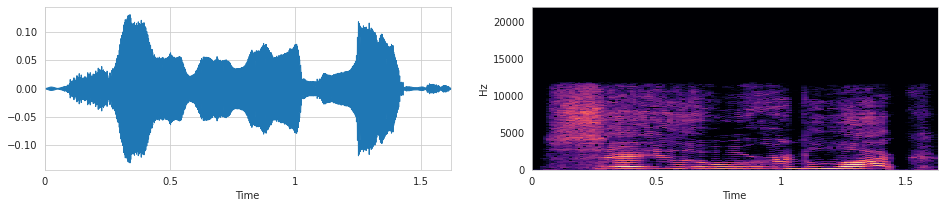

negative_female


((71450,), (1025, 140))

In [ ]:
def get_audio_data(path, calculate_db=False, calculate_mfccs=False, plots=False):
    data, sampling_rate = librosa.load(path, sr=44100)
    Xdb = None
    if calculate_db:
        X = librosa.stft(data)
        Xdb = librosa.amplitude_to_db(abs(X))
    mfccs = None
    if calculate_mfccs:
        mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc = 40)
    
    if calculate_db and plots:
        fig, ax = plt.subplots(1,2,figsize=(16, 3))
        plt.subplot(121)
        librosa.display.waveplot(data, sr=sampling_rate)
        plt.subplot(122)
        librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
        plt.show()
    elif plots:
        librosa.display.waveplot(data, sr=sampling_rate)

    return (data, Xdb, mfccs)
    
rnd = np.random.randint(1,100)    
arr0, arr1, _ = get_audio_data(df_combined.iloc[rnd].path, calculate_db=True,
                               calculate_mfccs=True, plots=True)
print(df_combined.iloc[rnd].values[-1])
arr0.shape, arr1.shape

## Preprocessing section - DISABLED

In [ ]:
# arr_wave, arr_spec, arr_mfccs = [], [], []
# for path in tqdm(df_combined.path.values):
    # a1, a2, a3 = get_audio_data(path, calculate_db=True)
    # arr_wave.append(a1)
    # arr_spec.append(a2)
    # arr_mfccs.append(a3)

In [ ]:
# pickle.dump(arr_wave, open( os.path.join(main_path, "arr_wave.pickle"), "wb" ))
# arr_wave = []

In [ ]:
# pickle.dump(arr_spec, open( os.path.join(main_path, "arr_spec.pickle"), "wb" ))
# arr_spec = []

In [ ]:
# pickle.dump(arr_mfccs, open( os.path.join(main_path, "arr_mfccs.pickle"), "wb" ))
# arr_mfccs = []

In [ ]:
# NN_data = []
# for a in tqdm(arr_spec):
# #     uint_img = np.array(a*255).astype('uint8')
# #     grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
#     img = np.stack((a,) * 3,-1)
#     img = img.astype(np.uint8)
#     grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     grayImage = cv2.resize(grayImage, (224, 224))
#     NN_data.append(grayImage)
    
# pickle.dump(NN_data, open( os.path.join(main_path, "NN_data.pickle"), "wb" )) 

# print(NN_data[:][:][0].shape)
# plt.imshow(grayImage)

## Load the files that we need

In [ ]:
path1 = os.path.join(main_path, 'arr_wave.pickle')
path2 = os.path.join(main_path, 'arr_spec.pickle')
path3 = os.path.join(main_path, 'arr_mfccs.pickle')
path4 = os.path.join(main_path, 'NN_data.pickle')

# with open(path1, "rb") as f:
#     arr_wave = pickle.load(f)
#     print("File 1 of 4 loaded")
    
# # with open(path2, "rb") as f:
# #     arr_spec = pickle.load(f)
# #     print("File 2 of 4 loaded")

with open(path3, "rb") as f:
    arr_mfccs = pickle.load(f)
    print("File 3 of 4 loaded")

# with open(path4, "rb") as f:
#     NN_data = pickle.load(f)
#     print("File 4 of 4 loaded")

File 3 of 4 loaded


## Cut the length

In [ ]:
mfccs_lens = [x.shape[1] for x in arr_mfccs]
mfccs_lens[:4], np.min(mfccs_lens)

([125, 139, 156, 140], 109)

In [ ]:
def cut_array(a, limit):
  assert len(a.shape) == 2
  if a.shape[1] > limit:
    a = a[:,:limit]
  return a

print("Example:")
a = arr_mfccs[0]
print("initial shape", a.shape)
a = cut_array(a, 100)
print("shape after cutting", a.shape)

Example:
initial shape (40, 125)
shape after cutting (40, 100)


In [ ]:
limit = np.min(mfccs_lens) # mimimal length of array
new_arr_mfccs = [cut_array(a, limit) for a in arr_mfccs]
new_arr_mfccs = np.array(new_arr_mfccs)
new_arr_mfccs.shape

(4720, 40, 109)

## Create two datasets for male and female voices

### Female

In [ ]:
female_idxs = [i[0] for i in enumerate(df_combined.emotion2.values) if "female" in i[1]]
# check
rnd = np.random.randint(1, len(female_idxs))
i = female_idxs[rnd]
print(df_combined.emotion2[i])
ipd.Audio(df_combined.path[i])

negative_female


In [ ]:
new_arr_mfccs_female = new_arr_mfccs[female_idxs,:,:]

In [ ]:
df_female = df_combined.loc[df_combined.actors == 'female']
df_female.emotion2.value_counts()

negative_female    1984
positive_female     992
neutral_female      544
Name: emotion2, dtype: int64

### Male

In [ ]:
male_idxs = [i[0] for i in enumerate(df_combined.emotion2.values) if not "female" in i[1]]
# check
rnd = np.random.randint(1, len(male_idxs))
i = male_idxs[rnd]
print(df_combined.emotion2[i])
ipd.Audio(df_combined.path[i])

negative_male


In [ ]:
new_arr_mfccs_male = new_arr_mfccs[male_idxs,:,:]

In [ ]:
df_male = df_combined.loc[df_combined.actors == 'male']
df_male.emotion3.value_counts()

negative_male    312
neutral_male     264
sad_male         156
positive_male    156
fear_male        156
surprise_male    156
Name: emotion3, dtype: int64

# BASELINE CNN MODEL

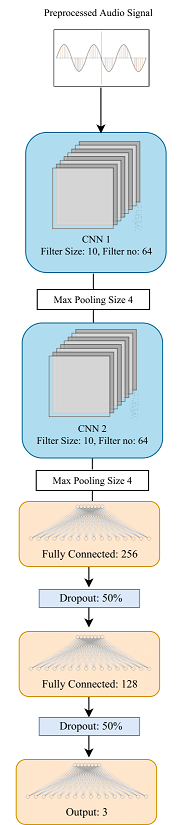

# Female emotion

## Train and test splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_arr_mfccs_female, 
                                                    df_female.emotion2.values, 
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=df_female.emotion2.values)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2816, 40, 109), (704, 40, 109), (2816,), (704,))

In [ ]:
# Our vectorized labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_female', 'neutral_female', 'positive_female'],
      dtype=object)

In [ ]:
inp_shape = (*X_train.shape[1:], 1)
inp_shape

(40, 109, 1)

## Model

In [ ]:
# build base model1 for mfccs
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(3))
model.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'female_model_weights.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

model.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 40, 64)            69824     
_________________________________________________________________
activation_83 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 10, 64)            41024     
_________________________________________________________________
activation_84 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
dropout_113 (Dropout)        (None, 10, 64)          

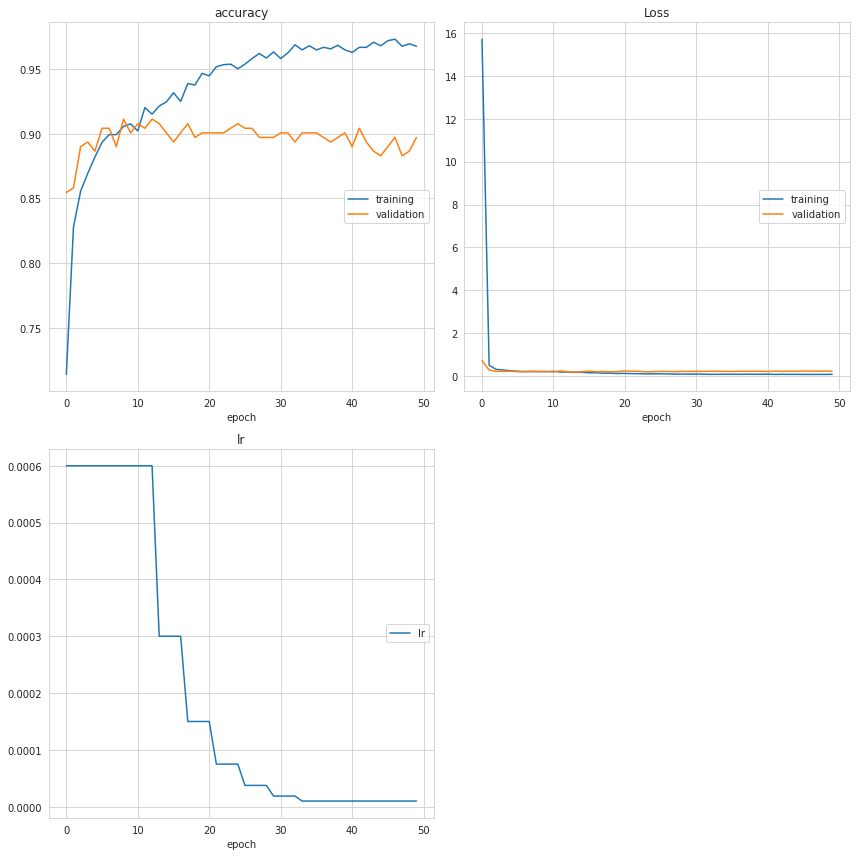

accuracy
	training         	 (min:    0.714, max:    0.973, cur:    0.968)
	validation       	 (min:    0.855, max:    0.911, cur:    0.897)
Loss
	training         	 (min:    0.076, max:   15.714, cur:    0.082)
	validation       	 (min:    0.189, max:    0.725, cur:    0.229)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr, PlotLossesKeras()])

                 precision    recall  f1-score   support

negative_female       0.90      0.97      0.93       397
 neutral_female       0.89      0.83      0.86       109
positive_female       0.98      0.85      0.91       198

       accuracy                           0.92       704
      macro avg       0.92      0.88      0.90       704
   weighted avg       0.92      0.92      0.92       704

Accuracy: 0.9162


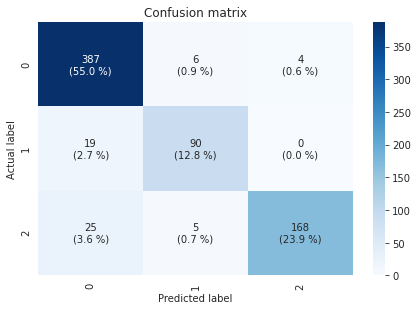

In [ ]:
# model.load_weights(os.path.join(main_path,'female_model_weights.hdf5'))
y_pred = model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
params = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

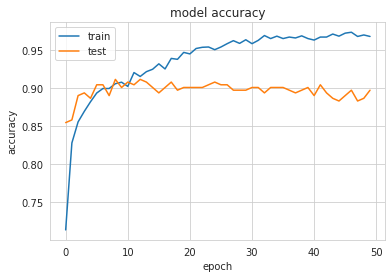

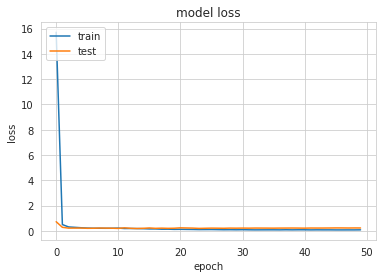

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Male emotion

## Train and test splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_arr_mfccs_male, 
                                                    df_male.emotion2.values, 
                                                    test_size=0.20, 
                                                    random_state=42,
                                                    stratify=df_male.emotion2.values)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((960, 40, 109), (240, 40, 109), (960,), (240,))

In [ ]:
# Our vectorized labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['fear_male', 'negative_male', 'neutral_male', 'positive_male',
       'sad_male', 'surprise_male'], dtype=object)

In [ ]:
inp_shape = (*X_train.shape[1:], 1)
inp_shape

(40, 109, 1)

## Model

In [ ]:
# build base model1 for mfccs
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv1D(64, 10, padding='same', input_shape=X_train.shape[1:]))
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model2.add(tf.keras.layers.Conv1D(64, 10,padding='same',))
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(256))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(128))
model2.add(tf.keras.layers.Dropout(0.1))

model2.add(tf.keras.layers.Dense(3))
model2.add(tf.keras.layers.Activation('softmax'))

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=2, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'male_model_weights.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

model2.compile(optimizer=Adam(lr=0.0006), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model2.load_weights(os.path.join(main_path,'male_model_weights.hdf5'))
model2.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 40, 64)            69824     
_________________________________________________________________
activation_95 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 10, 64)            41024     
_________________________________________________________________
activation_96 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 10, 64)          

In [ ]:
model2.input_shape, model2.output_shape

((None, 40, 109), (None, 3))

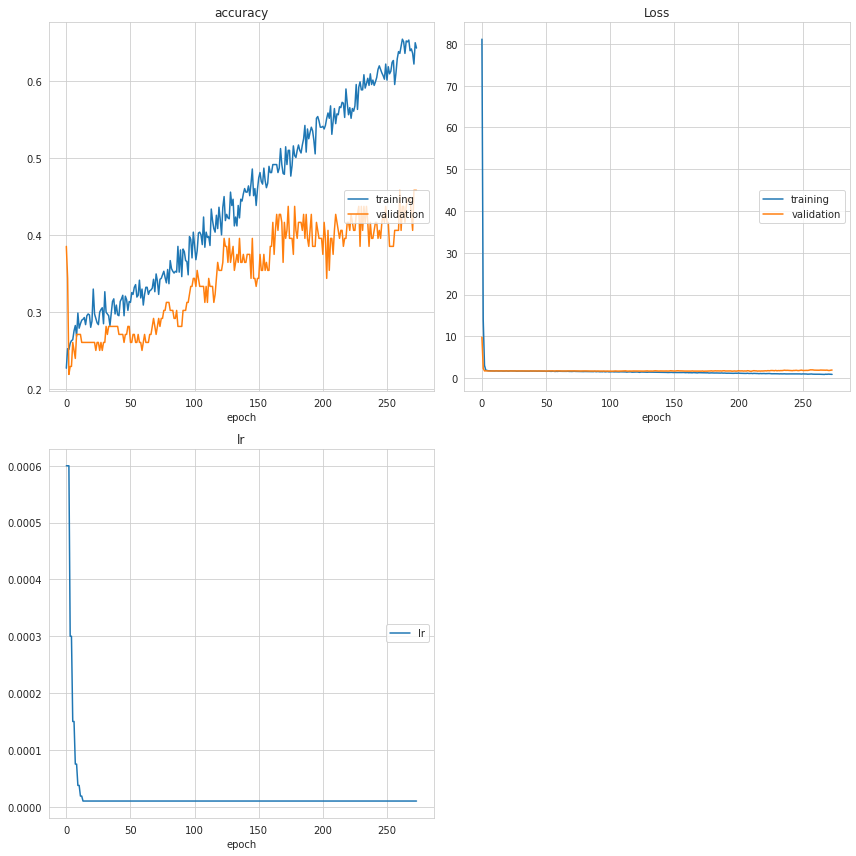

accuracy
	training         	 (min:    0.227, max:    0.655, cur:    0.644)
	validation       	 (min:    0.219, max:    0.458, cur:    0.458)
Loss
	training         	 (min:    0.868, max:   81.148, cur:    0.885)
	validation       	 (min:    1.634, max:    9.796, cur:    1.923)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 00274: early stopping


In [ ]:
history2 = model2.fit(X_train, y_train, batch_size=24, epochs=500, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr, PlotLossesKeras()])

               precision    recall  f1-score   support

negative_male       0.58      0.73      0.64       125
 neutral_male       0.45      0.32      0.37        53
positive_male       0.57      0.40      0.47        62

     accuracy                           0.55       240
    macro avg       0.53      0.48      0.50       240
 weighted avg       0.55      0.55      0.54       240

Accuracy: 0.5542


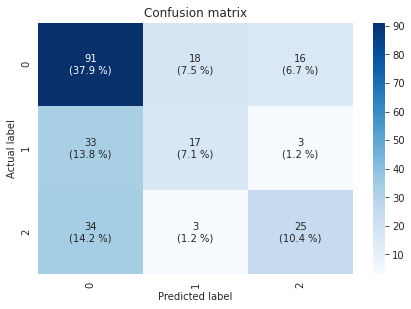

In [ ]:
# model2.save_weights(os.path.join(main_path,'male_model_weights.hdf5'), overwrite=True)
# model2.load_weights(os.path.join(main_path,'male_model_weights.hdf5'))

y_pred = model2.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
params2 = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

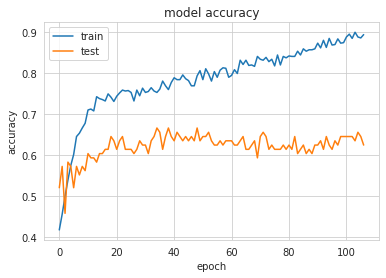

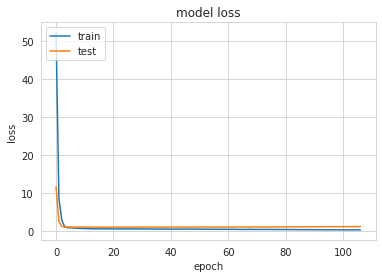

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TRANSFER LEARNING

In [ ]:
# !pip install livelossplot

In [ ]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

[]

In [ ]:
main_path = '/gdrive/MyDrive/Projects/ITCproject/'
TESS = os.path.join(main_path, "data3/")
RAV = os.path.join(main_path, "data/")
SAVEE = os.path.join(main_path, "data2/")

path0 = os.path.join(main_path, 'combined.csv')

df_combined = pd.read_csv(path0)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
1,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
2,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
3,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female
4,fear_female,TESS,female,/gdrive/MyDrive/Projects/ITCproject/data3/OAF_...,negative_female


Load an array of mel-spectrograms

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Load the files that we need

In [ ]:
################## repeat in the case we start from this section
path1 = os.path.join(main_path, 'arr_wave.pickle')
path2 = os.path.join(main_path, 'arr_spec.pickle')
path3 = os.path.join(main_path, 'arr_mfccs.pickle')
path4 = os.path.join(main_path, 'NN_data.pickle')
##################

with open(path4, "rb") as f:
    mel_images = pickle.load(f)
    print("File loaded")

File loaded


In [ ]:
mel_images = np.array(mel_images)
mel_images.shape

(4720, 224, 224)

In [ ]:
rgb_batch = np.repeat(mel_images[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (4720, 224, 224, 3)

(4720, 224, 224, 3)


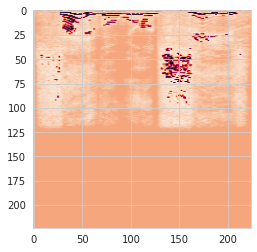

In [ ]:
rnd = np.random.randint(0,4720)
plt.imshow(mel_images[rnd])

In [ ]:
################## repeat in the case we start from this section
female_idxs = [i[0] for i in enumerate(df_combined.emotion2.values) if "female" in i[1]]
df_female = df_combined.loc[df_combined.actors == 'female']
##################

mel_images_female = rgb_batch[female_idxs,:,:,:]

## Train and test splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mel_images_female, df_female.emotion2.values, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2816, 224, 224, 3), (704, 224, 224, 3), (2816,), (704,))

In [ ]:
# Our vectorized labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['negative_female', 'neutral_female', 'positive_female'],
      dtype=object)

In [ ]:
inp_shape = (*X_train.shape[1:], 1)
inp_shape

(224, 224, 3, 1)

## Model

In [ ]:
pretrained_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                     weights='imagenet', 
                                                     input_shape=(224,224,3))
# pretrained_model.trainable = False
for layer in pretrained_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

pretrained_model.input_shape, pretrained_model.output_shape

74842112/74836368 [==============================] - 1s 0us/step


((None, 224, 224, 3), (None, 7, 7, 1920))

In [ ]:
transfer_model = tf.keras.models.Sequential()
transfer_model.add(pretrained_model)
transfer_model.add(tf.keras.layers.GlobalAveragePooling2D())
transfer_model.add(tf.keras.layers.Flatten())

transfer_model.add(tf.keras.layers.Dense(256))
transfer_model.add(tf.keras.layers.Dropout(0.2))

transfer_model.add(tf.keras.layers.Dense(128))
transfer_model.add(tf.keras.layers.Dropout(0.1))
transfer_model.add(tf.keras.layers.Dense(3, activation='softmax'))
# model.add(tf.keras.layers.Activation('softmax'))

transfer_model.compile(optimizer=Adam(lr=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(main_path,'weights_.hdf5'), 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               491776    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
transfer_model.input_shape, transfer_model.output_shape

((None, 224, 224, 3), (None, 3))

In [ ]:
thistory = transfer_model.fit(X_train, y_train, batch_size=16, epochs=500, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr])

Epoch 1/500
159/159 [==============================] - 535s 3s/step - loss: 33.9355 - accuracy: 0.4904 - val_loss: 0.7581 - val_accuracy: 0.6950
Epoch 2/500
159/159 [==============================] - 540s 3s/step - loss: 0.7650 - accuracy: 0.7132 - val_loss: 0.4046 - val_accuracy: 0.8369
Epoch 3/500
159/159 [==============================] - 541s 3s/step - loss: 0.5264 - accuracy: 0.8294 - val_loss: 0.2527 - val_accuracy: 0.9113
Epoch 4/500
159/159 [==============================] - 543s 3s/step - loss: 0.4758 - accuracy: 0.8483 - val_loss: 3.5439 - val_accuracy: 0.7872
Epoch 5/500
159/159 [==============================] - 543s 3s/step - loss: 1.9727 - accuracy: 0.7829 - val_loss: 0.4187 - val_accuracy: 0.8972
Epoch 6/500
159/159 [==============================] - 543s 3s/step - loss: 0.2672 - accuracy: 0.8921 - val_loss: 0.1759 - val_accuracy: 0.9397
Epoch 7/500
159/159 [==============================] - 544s 3s/step - loss: 0.2130 - accuracy: 0.9024 - val_loss: 0.1365 - val_accuracy

In [ ]:
transfer_model.save_weights('weights.hdf5')

                 precision    recall  f1-score   support

negative_female       0.96      0.96      0.96       410
 neutral_female       0.91      0.93      0.92       107
positive_female       0.95      0.94      0.95       187

       accuracy                           0.95       704
      macro avg       0.94      0.94      0.94       704
   weighted avg       0.95      0.95      0.95       704

Accuracy: 0.9517


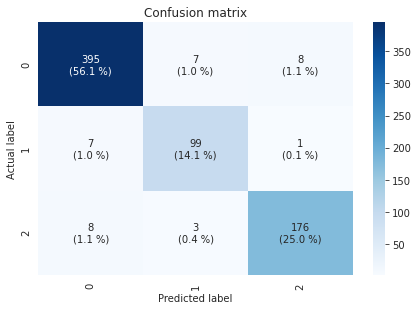

In [ ]:
transfer_model.load_weights('weights.hdf5')
# transfer_model.load_weights(os.path.join(main_path,'weights_.hdf5'))

y_pred = transfer_model.predict(X_test).argmax(axis=1)
# y_pred_ = model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))
tparams = report_res_and_plot_matrix(y_test, y_pred, le.classes_)

In [ ]:
y_pred.shape, np.array(y_test).shape, X_test.shape

((704, 7, 1920), (704,), (704, 224, 224, 3))

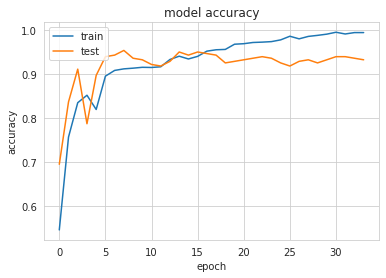

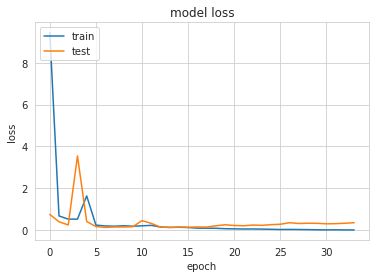

In [ ]:
# summarize history for accuracy
plt.plot(thistory.history['accuracy'])
plt.plot(thistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(thistory.history['loss'])
plt.plot(thistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()